In [53]:
import os
import matplotlib.pyplot as plt
import control as ct
import numpy as np

In [54]:
def model(z,u,k,Fext):
    x1 = z[0]
    x2 = z[1]
    x3 = z[2]
    x4 = z[3]
    
    m1 = 2
    m2 = 1
    b = 75
    dx1dt = x2
    dx2dt = -(k/m1)*x1 + (k/m1)*x3 - (b/m1)*x2 + u/m1
    dx3dt = x4
    dx4dt = (k/m2)*x1 -(k/m2)*x3 - Fext/m2
    return [dx1dt,dx2dt,dx3dt,dx4dt]

In [55]:
def forwardeuler(dz,z,step):
    z = z + step * dz
    return z

In [56]:
def poscont(x1,x2,posr,posrd):
    Kp = 2*5000.0
    Kd = 600.0
    u = Kp*(posr-x1) + Kd*(posrd - x2)
    return u

In [57]:
def forcecont(Fd, Fmeas, deltat,Fint):
    Md = 3.0
    Dd = 10.0
    Fe = Fd - Fmeas #error of force
    Fint = forwardeuler(Fe, Fint, deltat) #Integral of the force controller
    vref = 0.03*(Fint/Md + (Fe)/Dd) #input to the position controller
    return vref,Fint

In [58]:
def POPC(Fmeas, Fmeaspre,alphapre, vref2, deltat, Eprev):
    
    Wpre = Eprev/deltat
    F2 =  -Fmeas
    F2pre = -Fmeaspre
    eps = 1e-6
    #Passivity observer is designed as follows
    W = Wpre + vref2 * F2 + alphapre * (F2pre**2)
    if W <0:
        alpha = W/(F2**2+eps)
    else:
        alpha = 0
    
    vref1 = vref2 + 1*alpha*F2
    E = W*deltat
    return vref1,alpha,E

In [59]:
deltat = 0.0001
tf = 20
ti = 0
n = int(((tf-ti)/deltat)+1)
t = np.linspace(ti, tf, n)

#Fext[101:n] = 10
z = np.zeros(4)

x1 = np.zeros(n)
x2 = np.zeros(n)
x3 = np.zeros(n)
x4 = np.zeros(n)
k = 50000.0 #N/m
u = 0
uarr = np.zeros(n, dtype = np.float64)
alphaarr = np.zeros(n, dtype = np.float64)
vref2arr = np.zeros(n, dtype = np.float64)
vref1arr = np.zeros(n, dtype = np.float64)
xref1arr = np.zeros(n, dtype = np.float64)
Estor = np.zeros(n, dtype = np.float64)

Fext = np.zeros(n)
Fext[1001:n] = 10.0
#Fext = -10 * np.sin(t)
Fmeasarr = np.zeros(n)
Fint = 0.0
xref = 0.0


for i in range(1,n):
    dz = model(z,u,k,Fext[i])
    dz = np.array(dz)
    z = forwardeuler(dz,z,deltat)
    Fmeas = k*(z[0]-z[2])
    
    Fmeaspre = Fmeasarr[i-1]
    alphapre = alphaarr[i-1] 
    Eprev = Estor[i-1]
    
    
    vref2,Fint = forcecont(0.0, Fmeas, deltat,Fint)
    
    vref1 , alphaarr[i] , Estor[i] = POPC(Fmeas, Fmeaspre,alphapre, vref2,deltat,Eprev)
    
    xref = forwardeuler(vref1,xref,deltat)
    
    u = poscont(z[0],z[1],xref,vref1)

    uarr[i] = u
    
    x1[i] = z[0]
    x2[i] = z[1]
    x3[i] = z[2]
    x4[i] = z[3]
    vref2arr[i] = vref2
    vref1arr[i] = vref1
    xref1arr[i] = xref
    Fmeasarr[i] = Fmeas

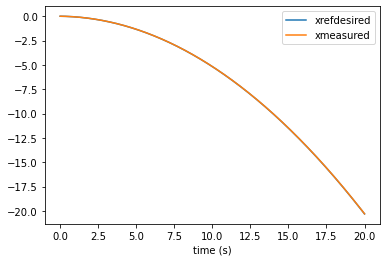

In [60]:
plt.figure(1)
plt.xlabel("time (s)")


plt.plot(t,xref1arr,label= 'xrefdesired')
plt.plot(t,x1,label = 'xmeasured')
plt.legend()

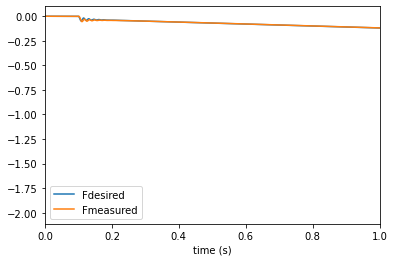

In [61]:
plt.figure(2)
plt.xlabel("time (s)")
plt.xlim(0,1)

plt.plot(t,vref1arr,label= 'Fdesired')
plt.plot(t,x2,label = 'Fmeasured')
plt.legend()

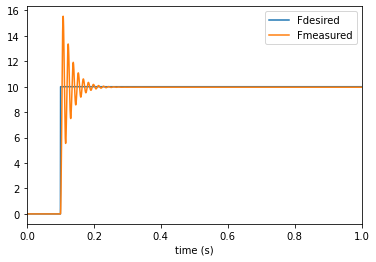

In [66]:
plt.figure(2)
plt.xlabel("time (s)")
plt.xlim(0,1)
plt.plot(t,Fext,label= 'Fdesired')
plt.plot(t,Fmeasarr,label= 'Fmeasured')

plt.legend()

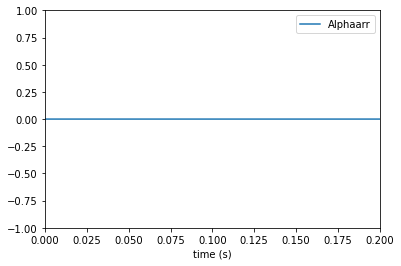

In [63]:
plt.figure(2)
plt.xlabel("time (s)")
plt.xlim(0,0.2)
plt.ylim(-1,1)
plt.plot(t,alphaarr,label= 'Alphaarr')

plt.legend()

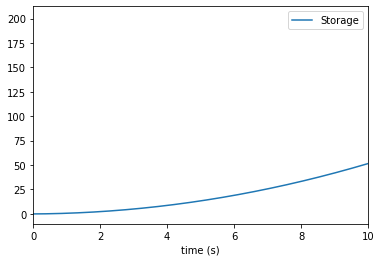

In [64]:
plt.figure(2)
plt.xlabel("time (s)")
plt.xlim(0,10)

plt.plot(t,Estor,label= 'Storage')

plt.legend()

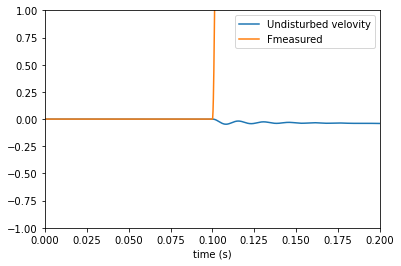

In [65]:
plt.figure(2)
plt.xlabel("time (s)")
plt.xlim(0,0.2)
plt.ylim(-1,1)
plt.plot(t,vref2arr,label= 'Undisturbed velovity')
plt.plot(t,Fmeasarr,label= 'Fmeasured')
plt.legend()